In [1]:
import tensorflow as tf
import numpy as np
import cv2

import matplotlib.pyplot as plt

from cell_division.nets.transfer_learning import CNN
from util.data.dataset_cell import CellDataset
from util import values as v
from util.misc import visualizer as vis
from util.misc.colors import bcolors as bc

from sklearn.metrics import classification_report, confusion_matrix
from cell_division.layers.custom_layers import (
    ExtendedLSEPooling,
    extended_w_cel_loss,
    extended_w_cel_loss_multiclass
)

from cell_division.nets.cam import overlay_heatmap, CAM, GradCAM, GradCAMpp

# GPU config
from util.gpu.gpu_tf import (
    increase_gpu_memory, 
    set_gpu_allocator
)
plt.style.use('default')

import os
import warnings

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')


increase_gpu_memory()
set_gpu_allocator()


Data

In [2]:
img_dir = v.data_path + 'CellDivision/images_nuclei/'
label_train_dir = v.data_path + 'CellDivision/undersampled/train.csv'
label_test_dir = v.data_path + 'CellDivision/undersampled/test.csv'
label_val_dir = v.data_path + 'CellDivision/undersampled/val.csv'

INPUT_SHAPE = (100, 100, 3)
BATCH_SIZE = 32

In [3]:
train_generator = CellDataset(
    img_dir, 
    label_train_dir,
    batch_size=BATCH_SIZE,
    resize=INPUT_SHAPE[:2]
)

val_generator = CellDataset(
    img_dir, 
    label_val_dir,
    batch_size=BATCH_SIZE,
    resize=INPUT_SHAPE[:2]
)

test_generator = CellDataset(
    img_dir, 
    label_test_dir,
    batch_size=BATCH_SIZE,
    resize=INPUT_SHAPE[:2]
)

Training

In [4]:
model = CNN(
    base=tf.keras.applications.VGG16,
    input_shape=INPUT_SHAPE,
    n_classes=3
)
model.build_top(
    activation='softmax', b_type='CAM', 
    pooling=ExtendedLSEPooling
)
model.compile(
    lr=.001,
    loss=extended_w_cel_loss_multiclass(from_logits=True),
)

In [5]:
# model.fit(
#     train_generator,
#     val_generator,
#     epochs=100,
#     verbose=2,
#     batch_size=BATCH_SIZE
# )

# model.model.save('../models/cellular_division_models/vgg16_nuclei_under.h5')

In [33]:
model.load('../models/cellular_division_models/vgg16_nuclei_under.h5')
# model.load('../models/cellular_division_models/vgg16_semi.h5')

In [7]:
model.model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0   

Testing

In [7]:
results = model.model.evaluate(test_generator, verbose=1)

4/4 [==============================] - 6s 729ms/step - loss: 1.3343 - auc: 0.9461


In [8]:
pred = model.model.predict(test_generator).round().astype(int)

print(
    classification_report(
        test_generator.img_labels, [test_generator.oh2class(p) for p in pred], 
        target_names=test_generator.CLASS_NAMES,
        zero_division=0
    )
)

                    precision    recall  f1-score   support

Prophase/Metaphase       0.75      0.95      0.84        42
Anaphase/Telophase       0.88      0.71      0.79        42
        Interphase       0.93      0.86      0.89        43

          accuracy                           0.84       127
         macro avg       0.85      0.84      0.84       127
      weighted avg       0.85      0.84      0.84       127



<Figure size 1200x1200 with 0 Axes>

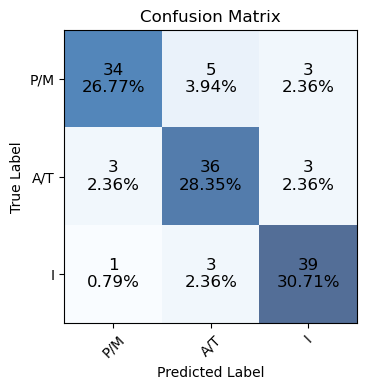

In [10]:
cf_matrix = confusion_matrix(
    test_generator.img_labels, [test_generator.oh2class(p) for p in pred]
)

plt.figure(figsize=(12, 12))
vis.plot_confusion_matrix(cf_matrix)

Grad-CAM

In [9]:
test_generator = CellDataset(
    img_dir, 
    label_test_dir, 
    batch_size=1, 
    resize=INPUT_SHAPE[:2]
)

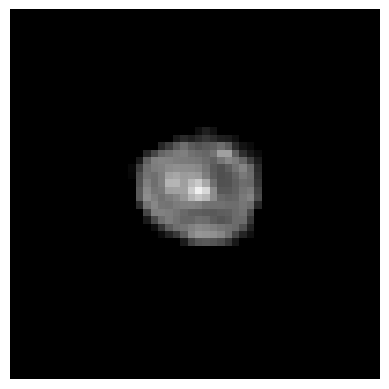

In [10]:
img_idx = 25 # 87 # 44 # 40 # 0  # 98  # 25
test_img_tf = test_generator[img_idx][0]
test_img = test_img_tf.numpy().astype(np.float32)
test_img = test_img.reshape(INPUT_SHAPE)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

plt.imshow(test_img); plt.axis('off')
plt.show()

Real label: Interphase
Predicted label: Interphase


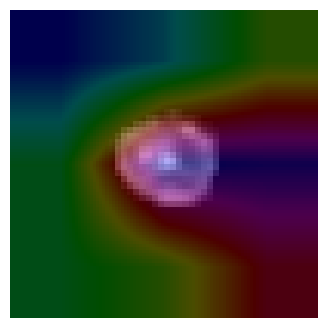

In [11]:
cam = CAM(model.model)
pred = model.model.predict(test_img_tf)
print(f'Real label: {test_generator.oh2name(test_generator[img_idx][1])}')
print(f'Predicted label: {test_generator.oh2name(pred)}')

pred_idx = np.argmax(pred)
heatmap = cam.compute_heatmap(test_img_tf, class_idx=pred_idx)

plt.figure(figsize=(4, 4))
plt.imshow(overlay_heatmap(test_img, heatmap, alpha=.7, colormap=cv2.COLORMAP_HSV))
plt.axis('off')
plt.show()

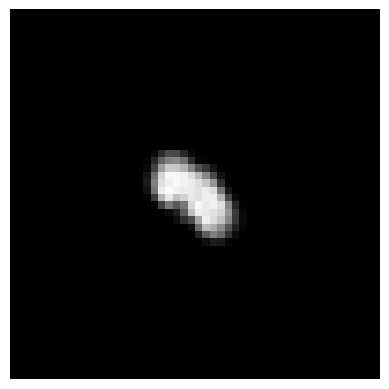

In [32]:
img_idx = 98 #35 # 87 # 44 # 40 # 0  # 98  # 25

test_img_tf = test_generator[img_idx][0]
test_img = test_img_tf.numpy().astype(np.float32)
test_img = test_img.reshape(INPUT_SHAPE)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

plt.imshow(test_img); plt.axis('off')
plt.show()

Real label: Interphase
Predicted label: Interphase


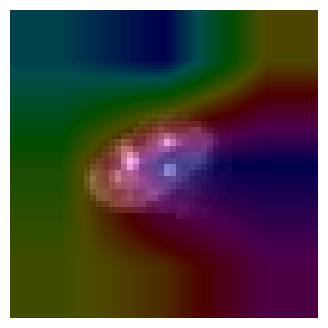

In [31]:
cam = CAM(model.model)
pred = model.model.predict(test_img_tf)
print(f'Real label: {test_generator.oh2name(test_generator[img_idx][1])}')
print(f'Predicted label: {test_generator.oh2name(pred)}')

pred_idx = np.argmax(pred)
heatmap = cam.compute_heatmap(test_img_tf, class_idx=pred_idx)

plt.figure(figsize=(4, 4))
plt.imshow(overlay_heatmap(test_img, heatmap, alpha=.7, colormap=cv2.COLORMAP_HSV))
plt.axis('off')
plt.show()

Test calibrarion necessity

1. Negative Log-Likelihood (NLL) Check:

    - NLL measures how well the model’s predicted probability distribution matches the true distribution of labels.
    - If the NLL is much higher than expected, it can indicate that the model is overconfident in its predictions, which often correlates with miscalibration.
    - A low NLL means the model’s probabilistic predictions are aligned with the actual outcomes, suggesting that calibration may not be necessary.

2. Reliability Diagrams and Confidence Histograms:

    - Before applying any calibration, confidence histograms and reliability diagrams help visually inspect miscalibration.
    - A confidence histogram shows the distribution of the model’s confidence in its predictions. If most predictions have high confidence but the accuracy does not match, it signals overconfidence and thus, miscalibration.
    - Reliability diagrams plot accuracy against confidence. A well-calibrated model’s reliability diagram should closely align with the diagonal. Significant deviations from the diagonal indicate the need for calibration.

3. Expected Calibration Error (ECE):

    - The ECE metric provides a more quantitative assessment. High ECE values indicate a significant difference between confidence and accuracy, suggesting that calibration is needed.

In [16]:
from cell_division.calibration_assessment import (
    plot_reliability_diagram,
    plot_calibration_map,
    plot_learned_calibration_map,
    compute_ece,
    compute_multilabel_brier,
    plot_confidence_histogram,
    NLL,
    plot_learned_calibration_map_prob
)

In [17]:
probs = model.model.predict(val_generator)
labels = val_generator.class2oh(val_generator.img_labels)

Negative Log-Likelihood: 0.4466444707995453


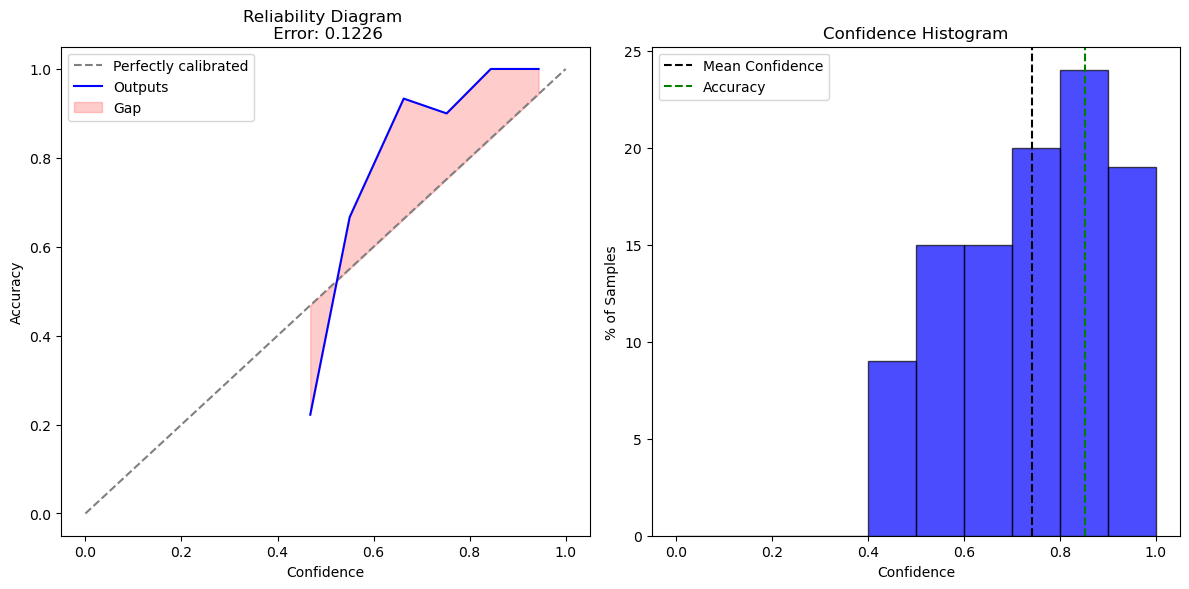

In [18]:
plt.figure(figsize=(12, 6))
plot_reliability_diagram(
    labels, probs, 
    sub_index=1, nrows=1, ncols=2
)
plot_confidence_histogram(
    labels, probs, 
    sub_index=2, nrows=1, ncols=2
)
print(f'{bc.OKBLUE}Negative Log-Likelihood:{bc.ENDC} {NLL(probs, labels)}')

Negative Log-Likelihood: 0.48782168586587393


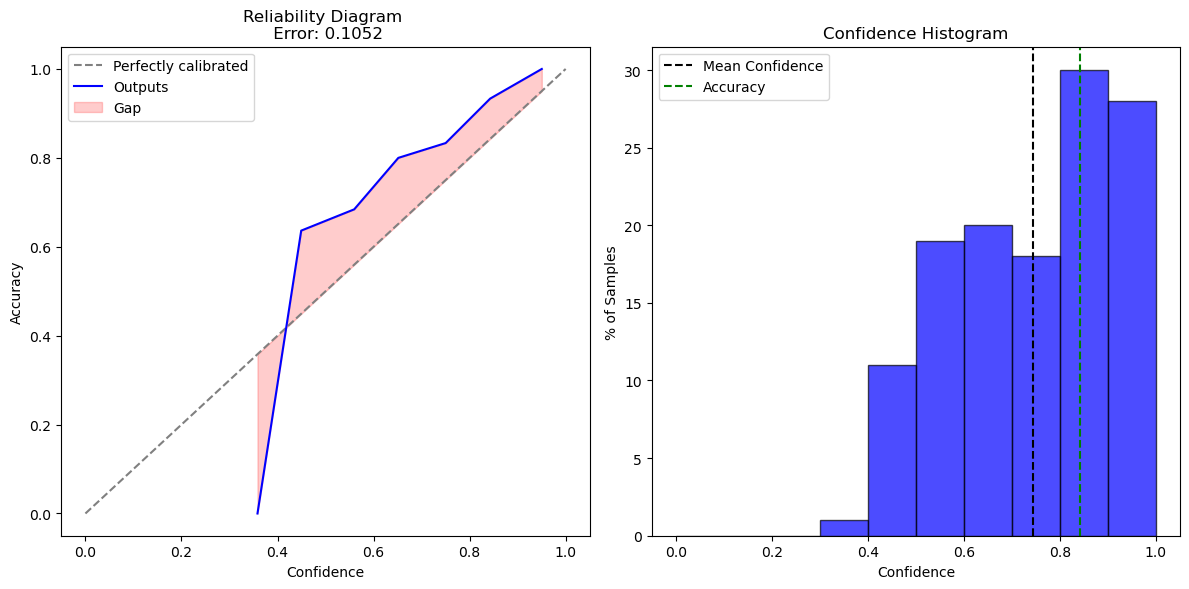

In [19]:
probs = model.model.predict(test_generator)
labels = test_generator.class2oh(test_generator.img_labels)

plt.figure(figsize=(12, 6))
plot_reliability_diagram(
    labels, probs, 
    sub_index=1, nrows=1, ncols=2
)
plot_confidence_histogram(
    labels, probs, 
    sub_index=2, nrows=1, ncols=2
)
print(f'{bc.OKBLUE}Negative Log-Likelihood:{bc.ENDC} {NLL(probs, labels)}')

Model calibration

In [20]:
def print_calibration_results(model, calibrated_model, calibrated_pred, results, generator, method, X_test, y_test):    
    print(f'\t{bc.OKBLUE}Test results:{bc.ENDC}')
    res = calibrated_model.evaluate(generator, verbose=1)
    print(res)
    
    print(f'\t{bc.OKBLUE}Test classification report:{bc.ENDC}')
    print(
        classification_report(
            generator.img_labels, 
            [generator.oh2class(p) for p in calibrated_pred], target_names=generator.CLASS_NAMES, zero_division=0
        )
    )
    
    ece = compute_ece(y_test, calibrated_pred)
    print(f'\t{bc.OKBLUE}Expected Calibration Error:{bc.ENDC} {ece:.4f}')
    
    nll = NLL(calibrated_pred, y_test)
    print(f'\t{bc.OKBLUE}Negative Log-Likelihood:{bc.ENDC} {nll:.4f}')
    
    brier = compute_multilabel_brier(y_test, calibrated_pred)
    print(f'\t{bc.OKBLUE}Multilabel Brier score:{bc.ENDC} {brier:.4f}')
    
    plt.figure(figsize=(18, 12))
    plt.subplot(2, 3, 1)
    
    cf_matrix = confusion_matrix(
        generator.img_labels, 
        [generator.oh2class(p) for p in calibrated_pred]
    )
    vis.plot_confusion_matrix(cf_matrix, sub_index=1, nrows=2, ncols=3)
    
    plot_reliability_diagram(
        y_test, calibrated_pred,
        sub_index=2, nrows=2, ncols=3
    )
    
    plot_confidence_histogram(
        y_test, calibrated_pred,
        sub_index=3, nrows=2, ncols=3
    )
    
    if method != 'none':
        plot_calibration_map(
            model, calibrated_model,
            X_test, generator.img_labels, title='Calibration map',
            sub_index=4, nrows=2, ncols=3
        )
        
        if method == 'dirichlet':
            plot_learned_calibration_map_prob(
                calibrated_model,
                'Learned calibration map',
                sub_index=5, nrows=2, ncols=3
            )
        else:
            plot_learned_calibration_map(
                calibrated_model,
                'Learned calibration map',
                sub_index=5, nrows=2, ncols=3
            )
    
    plt.show()
    
    try:
        results['method'].append(method)
        results['test_results'].append(res)
        results['ece'].append(ece)
        results['brier'].append(brier)
        results['NLL'].append(nll)
        calibrated_model.save(
            f'../models/cellular_division_models/vgg16_nuclei_under_calibrated_{method}.h5'
        )
    except Exception as e:
        pass
    
    return results
    
def compute_calibrations(model, X_calib, y_calib, X_test, y_test, methods, generator):
    
    results = {
        'method': [],
        'test_results': [],
        'ece': [],
        'brier': [],
        'NLL': []
    }
    
    for method in methods:
        if method == 'none':
            results = print_calibration_results(
                model.model, model.model, 
                model.model.predict(X_test), results, generator, method,
                X_test, y_test
            )
            continue
        
        model.calibrate(X_calib, y_calib, method=method)
        calibrated_pred = model.calibrated_model.predict(X_test)

        print(model.calibrated_model.summary())

        print(f'{bc.OKGREEN}Calibration method:{bc.ENDC} {method}')
        print(f'\t{bc.OKBLUE}Weights:{bc.ENDC}')
        print(model.calibrated_model.weights[-1])
        
        model.calibrated_model.save(
            f'./vgg16_nuclei_under_calibrated_{method}.h5'
        )
        
        results = print_calibration_results(
            model.model, model.calibrated_model, 
            calibrated_pred, results, generator, method,
            X_test, y_test
        )
        
    return results        

In [21]:
calibration_generator = CellDataset(
    img_dir, 
    label_val_dir,
    batch_size=1,
    resize=INPUT_SHAPE[:2]
)

X_calib, y_calib = calibration_generator.get_all()
print(X_calib.shape, y_calib.shape)

X_test, y_test = val_generator.get_all()
print(X_test.shape, y_test.shape)

(102, 100, 100, 3) (102, 3)
(102, 100, 100, 3) (102, 3)


	Test results:
4/4 [==============================] - 3s 571ms/step - loss: 1.3409 - auc: 0.9586
[1.340901255607605, 0.9586216807365417]
	Test classification report:
                    precision    recall  f1-score   support

Prophase/Metaphase       0.84      0.91      0.87        34
Anaphase/Telophase       0.82      0.79      0.81        34
        Interphase       0.91      0.85      0.88        34

          accuracy                           0.85       102
         macro avg       0.85      0.85      0.85       102
      weighted avg       0.85      0.85      0.85       102

	Expected Calibration Error: 0.1226
	Negative Log-Likelihood: 0.4466
	Multilabel Brier score: 0.0761


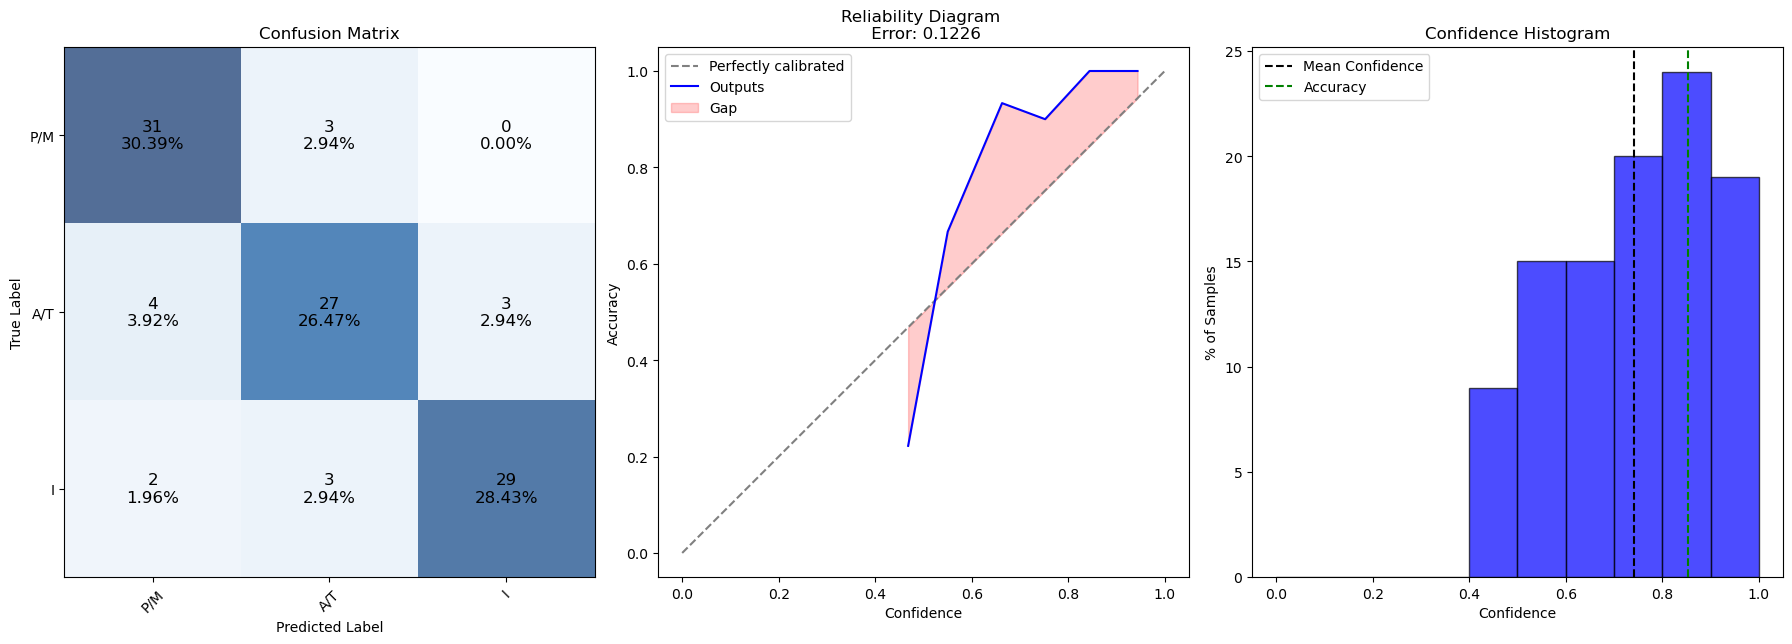

Trainable variables:  1
temperature:0
Epoch 1/100
4/4 [==============================] - 2s 100ms/step - loss: 2.7930 - auc: 0.9290 - lr: 0.0500
Epoch 2/100
4/4 [==============================] - 0s 31ms/step - loss: 2.7261 - auc: 0.9335 - lr: 0.0500
Epoch 3/100
4/4 [==============================] - 0s 98ms/step - loss: 2.5876 - auc: 0.9205 - lr: 0.0500
Epoch 4/100
4/4 [==============================] - 0s 24ms/step - loss: 2.3835 - auc: 0.9327 - lr: 0.0500
Epoch 5/100
4/4 [==============================] - 0s 103ms/step - loss: 2.1969 - auc: 0.9117 - lr: 0.0500
Epoch 6/100
4/4 [==============================] - 0s 105ms/step - loss: 3.0489 - auc: 0.6474 - lr: 0.0500
Epoch 7/100
4/4 [==============================] - 0s 109ms/step - loss: 4.2181 - auc: 0.1170 - lr: 0.0500
Epoch 8/100
4/4 [==============================] - 0s 107ms/step - loss: 4.0463 - auc: 0.0947 - lr: 0.0500
Epoch 9/100
4/4 [==============================] - 0s 25ms/step - loss: 3.8929 - auc: 0.1009 - lr: 0.0500
Epo

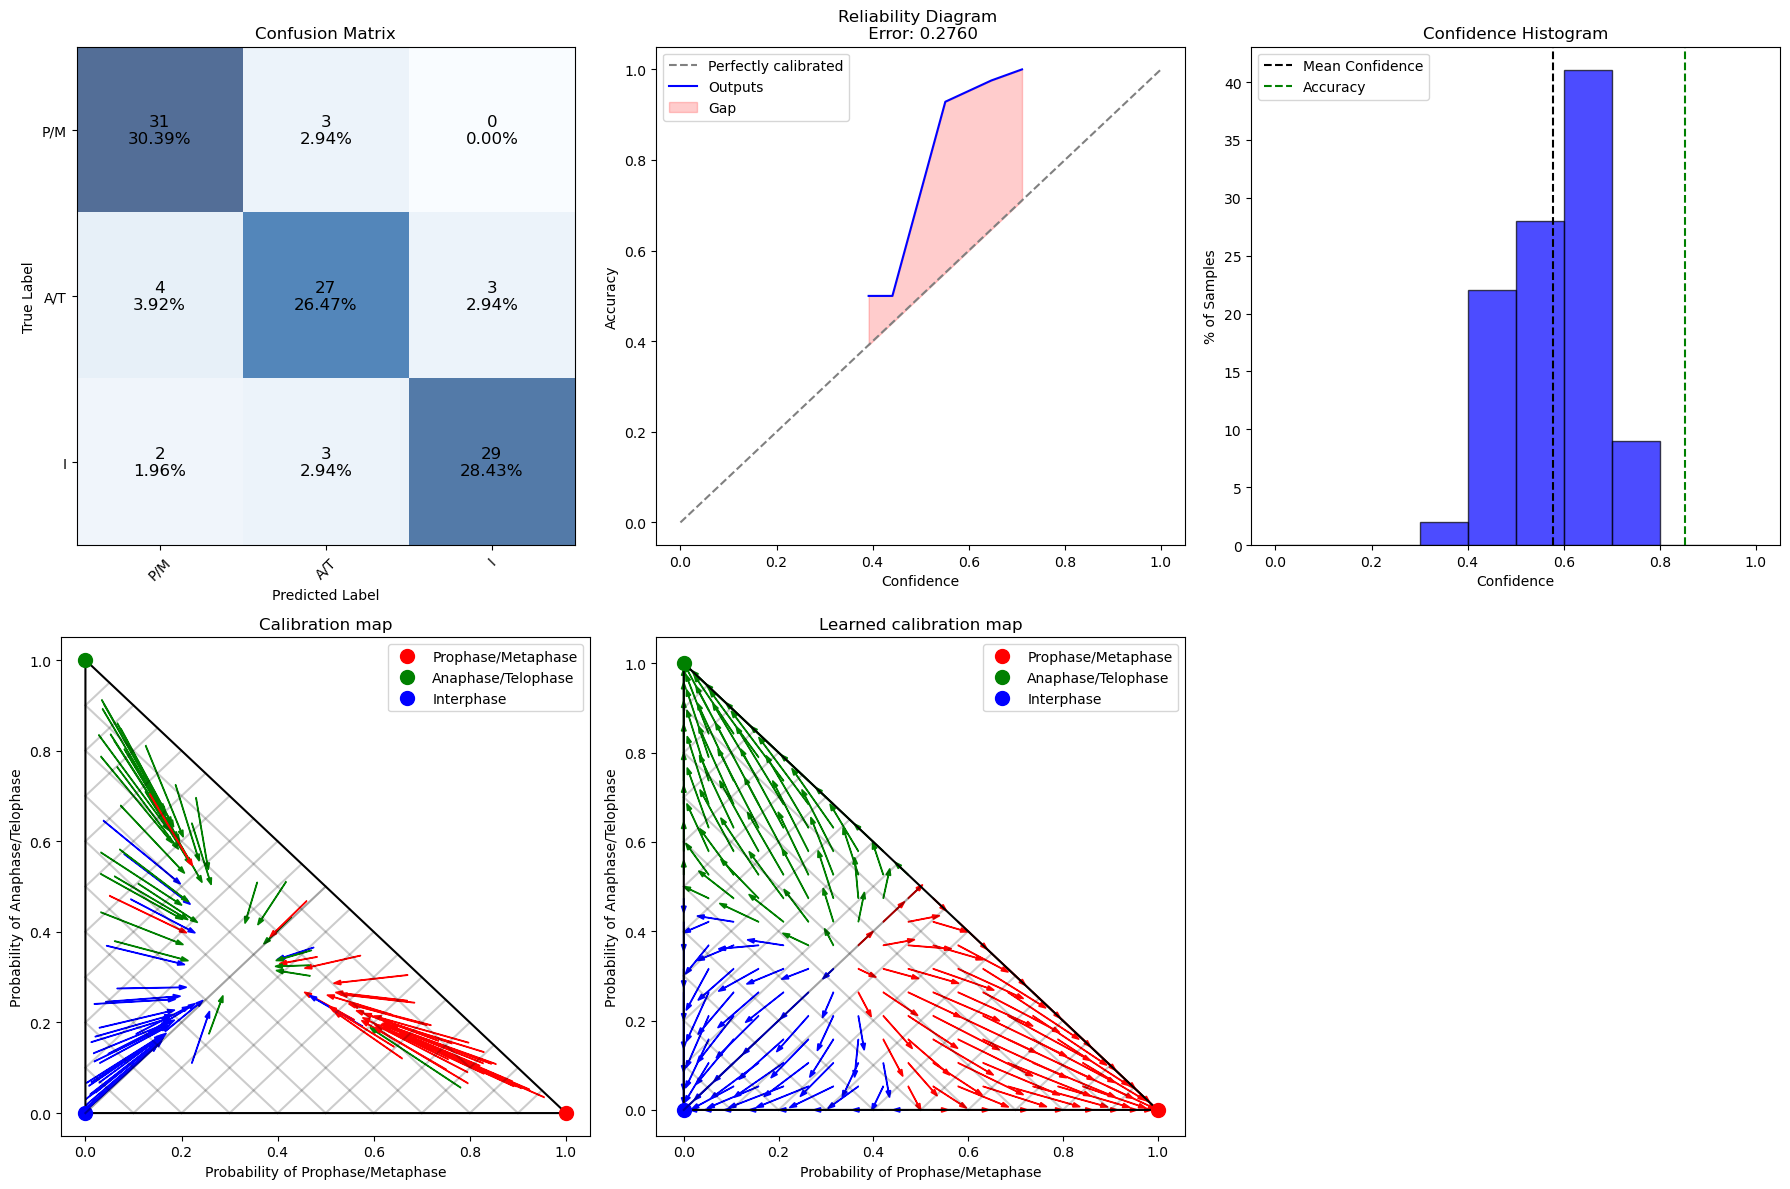

Trainable variables:  2
scale:0
bias:0
Epoch 1/100
4/4 [==============================] - 2s 122ms/step - loss: 2.8817 - auc: 0.9131 - lr: 0.0500
Epoch 2/100
4/4 [==============================] - 0s 37ms/step - loss: 2.7491 - auc: 0.9365 - lr: 0.0500
Epoch 3/100
4/4 [==============================] - 0s 32ms/step - loss: 2.6979 - auc: 0.9387 - lr: 0.0500
Epoch 4/100
4/4 [==============================] - 0s 109ms/step - loss: 2.7407 - auc: 0.9026 - lr: 0.0500
Epoch 5/100
4/4 [==============================] - 0s 35ms/step - loss: 2.5791 - auc: 0.9418 - lr: 0.0500
Epoch 6/100
4/4 [==============================] - 0s 21ms/step - loss: 2.5697 - auc: 0.9118 - lr: 0.0500
Epoch 7/100
4/4 [==============================] - 0s 21ms/step - loss: 2.4943 - auc: 0.9392 - lr: 0.0500
Epoch 8/100
4/4 [==============================] - 0s 33ms/step - loss: 2.4421 - auc: 0.9438 - lr: 0.0500
Epoch 9/100
4/4 [==============================] - ETA: 0s - loss: 2.4344 - auc: 0.9176
Epoch 9: ReduceLROnPlat

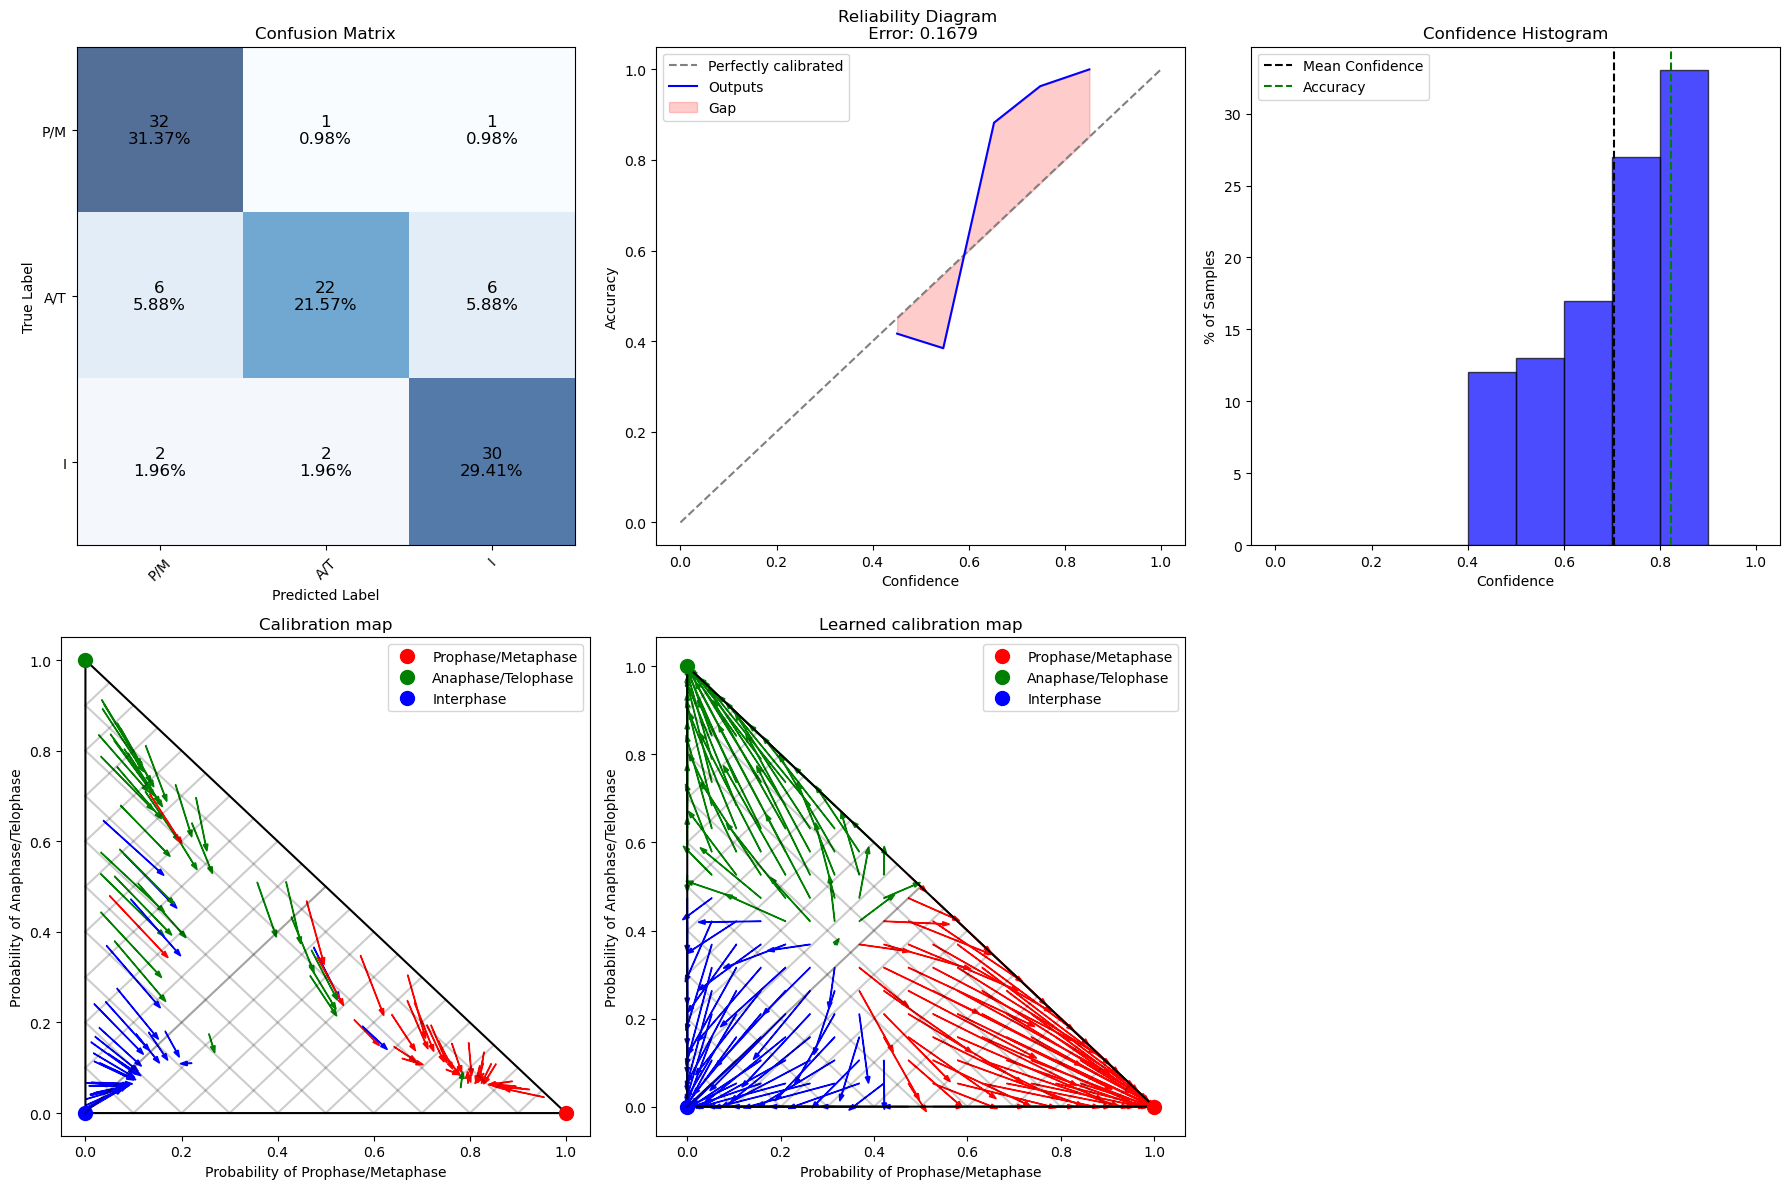

Trainable variables:  2
W:0
b:0
Epoch 1/100
4/4 [==============================] - 3s 134ms/step - loss: 2.8557 - auc: 0.8915 - lr: 0.0500
Epoch 2/100
4/4 [==============================] - 0s 37ms/step - loss: 2.7427 - auc: 0.9056 - lr: 0.0500
Epoch 3/100
4/4 [==============================] - 0s 30ms/step - loss: 2.6405 - auc: 0.9133 - lr: 0.0500
Epoch 4/100
4/4 [==============================] - 0s 29ms/step - loss: 2.5984 - auc: 0.9252 - lr: 0.0500
Epoch 5/100
4/4 [==============================] - 0s 20ms/step - loss: 2.4776 - auc: 0.9179 - lr: 0.0500
Epoch 6/100
4/4 [==============================] - ETA: 0s - loss: 2.3935 - auc: 0.9304
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.005000000074505806.
4/4 [==============================] - 0s 31ms/step - loss: 2.3935 - auc: 0.9304 - lr: 0.0500
Epoch 7/100
4/4 [==============================] - 0s 30ms/step - loss: 2.3686 - auc: 0.9316 - lr: 0.0050
Epoch 8/100
4/4 [==============================] - 0s 20ms/step - loss: 2.

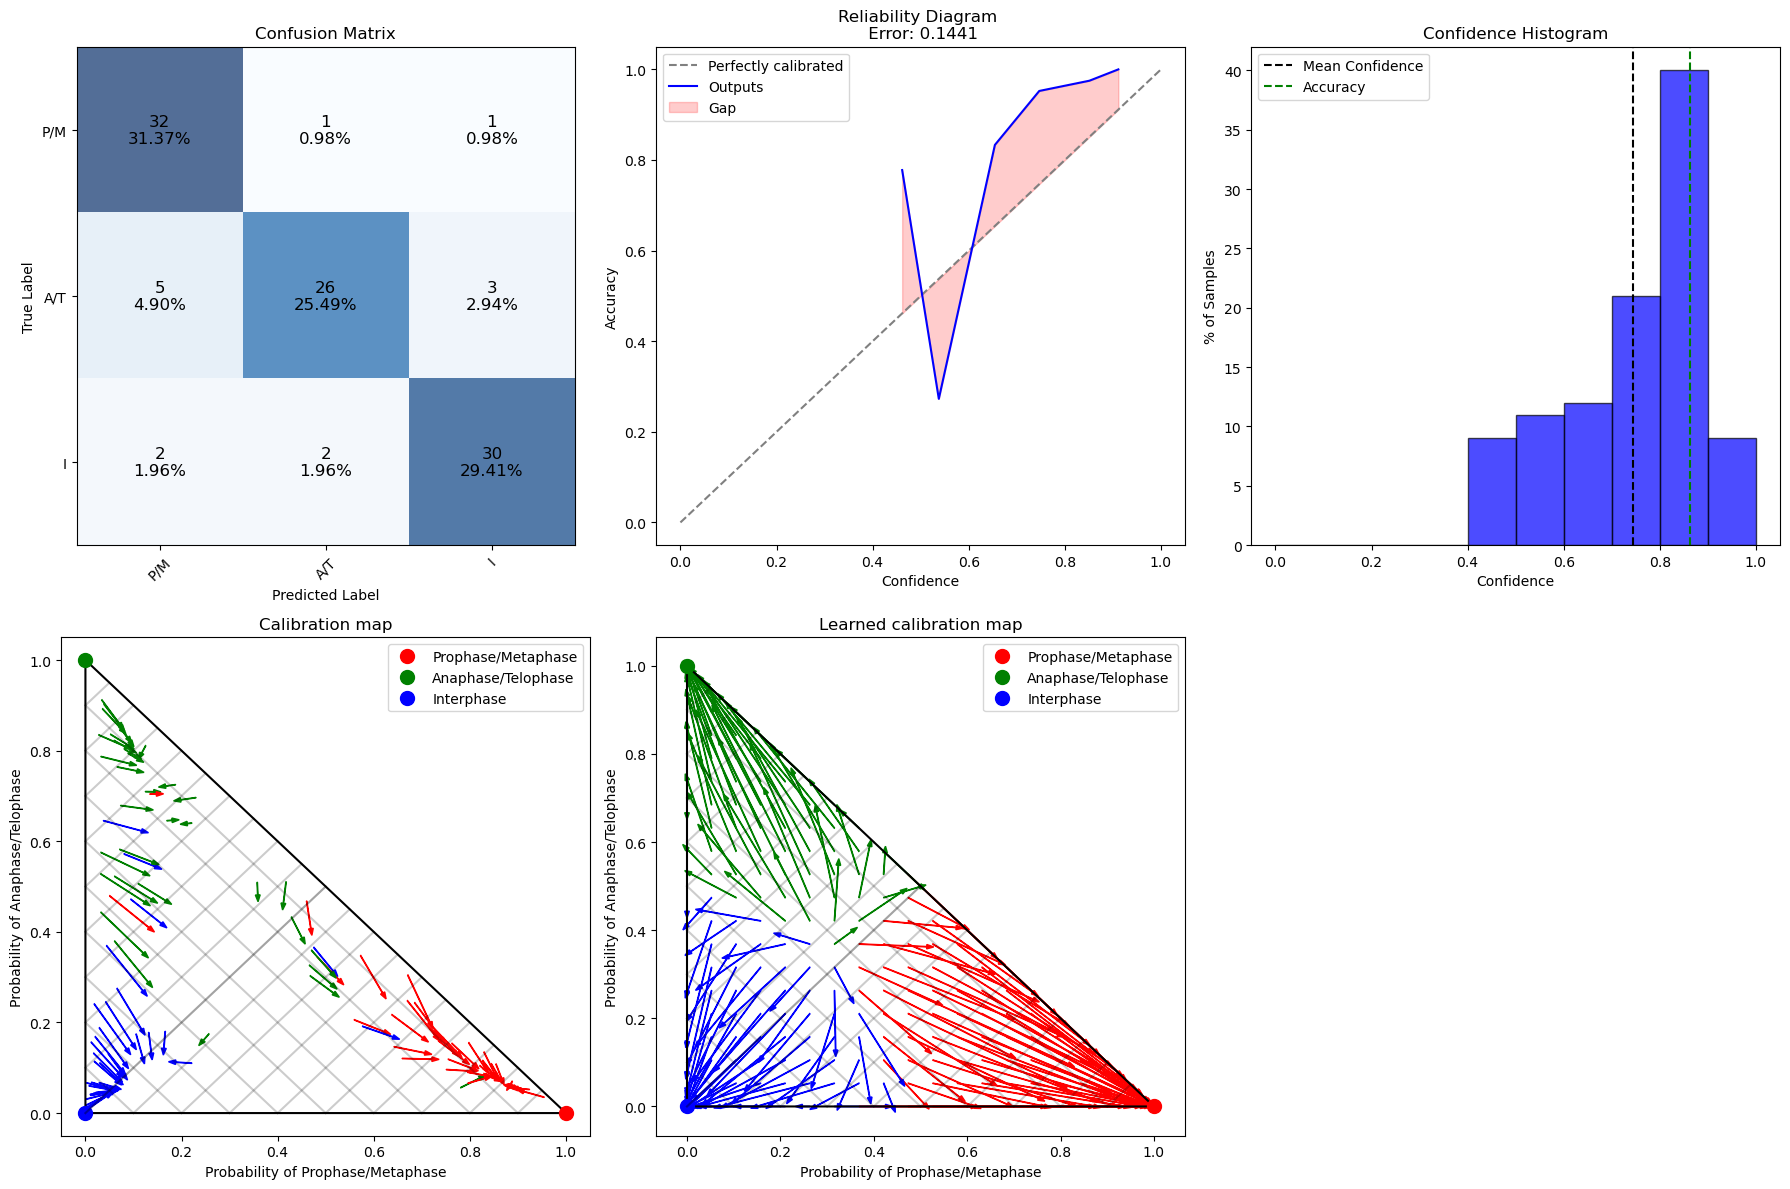

Trainable variables:  1
alpha:0
Epoch 1/100
4/4 [==============================] - 2s 128ms/step - loss: 2.4560 - auc: 0.9174 - lr: 0.0500
Epoch 2/100
4/4 [==============================] - 0s 35ms/step - loss: 2.3414 - auc: 0.9252 - lr: 0.0500
Epoch 3/100
4/4 [==============================] - 0s 114ms/step - loss: 2.3459 - auc: 0.9020 - lr: 0.0500
Epoch 4/100
4/4 [==============================] - 0s 39ms/step - loss: 2.3400 - auc: 0.9255 - lr: 0.0500
Epoch 5/100
4/4 [==============================] - 1s 298ms/step - loss: 2.3800 - auc: 0.9001 - lr: 0.0500
Epoch 6/100
4/4 [==============================] - 0s 23ms/step - loss: 2.3063 - auc: 0.9138 - lr: 0.0500
Epoch 7/100
4/4 [==============================] - 0s 31ms/step - loss: 2.3174 - auc: 0.9273 - lr: 0.0500
Epoch 8/100
4/4 [==============================] - 0s 22ms/step - loss: 2.2973 - auc: 0.9213 - lr: 0.0500
Epoch 9/100
4/4 [==============================] - 0s 33ms/step - loss: 2.1977 - auc: 0.9295 - lr: 0.0500
Epoch 10/10

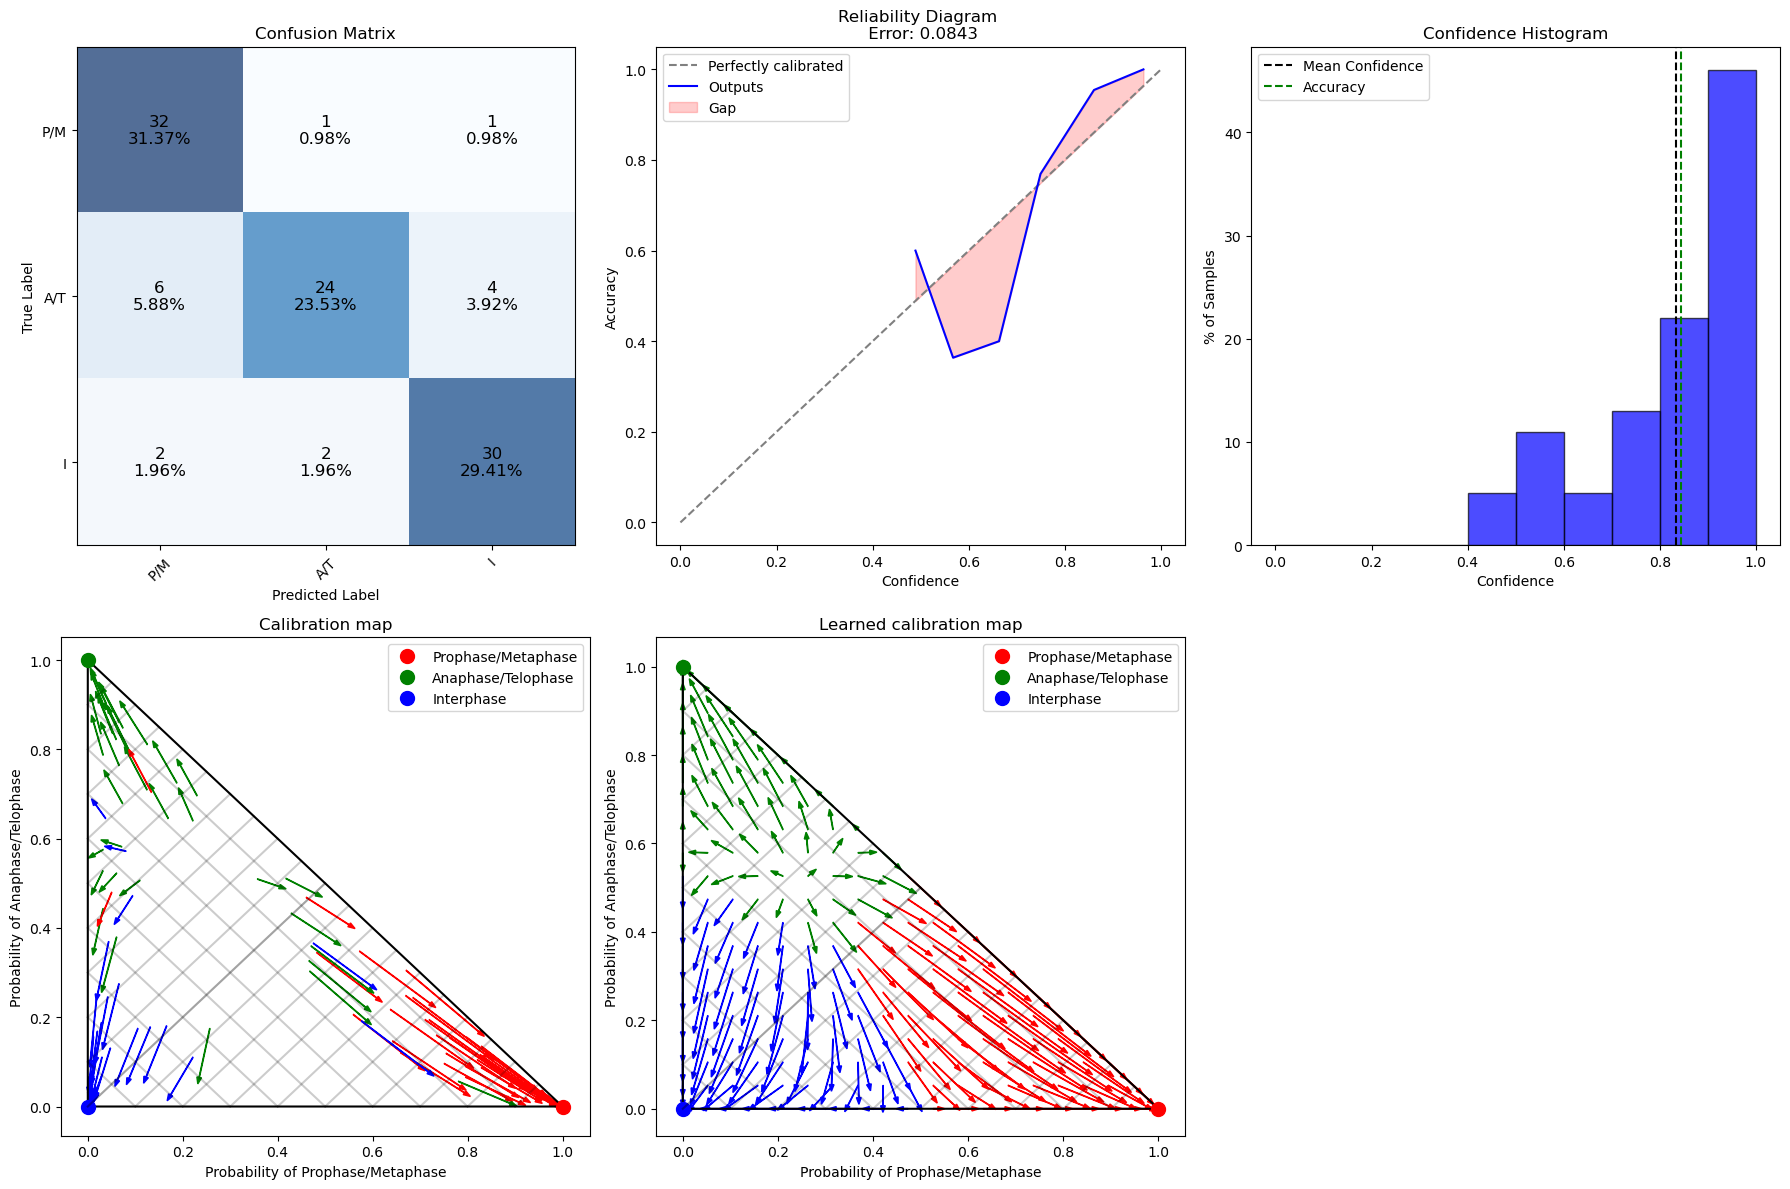

In [22]:
results = compute_calibrations(
    model, X_calib, y_calib, X_test, y_test, 
    ['none', 'temperature', 'vector', 'matrix', 'dirichlet'],
    val_generator
)

In [23]:
import pandas as pd
pd.DataFrame(results)

,method,test_results,ece,brier,NLL
0,none,"[1.340901255607605, 0.9586216807365417]",0.122556,0.076094,0.446644
1,temperature,"[2.6874942779541016, 0.9632353186607361]",0.275964,0.110531,0.630917
2,vector,"[2.437286615371704, 0.9650375247001648]",0.167938,0.084123,0.498363
3,matrix,"[2.3500125408172607, 0.9648933410644531]",0.144119,0.075115,0.447151
4,dirichlet,"[2.200200080871582, 0.9617214798927307]",0.084308,0.070969,0.411276


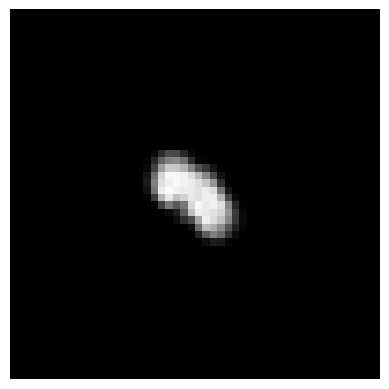

Real label: Anaphase/Telophase
Predicted label: Anaphase/Telophase


In [24]:
img_idx = 98 # 35 # 87 # 44 # 40 # 0  # 98  # 25
test_img_tf = test_generator[img_idx][0]
test_img = test_img_tf.numpy().astype(np.float32)
test_img = test_img.reshape(INPUT_SHAPE)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

plt.imshow(test_img); plt.axis('off')
plt.show()

pred = model.calibrated_model.predict(test_img_tf)
print(f'Real label: {test_generator.oh2name(test_generator[img_idx][1])}')
print(f'Predicted label: {test_generator.oh2name(pred)}')

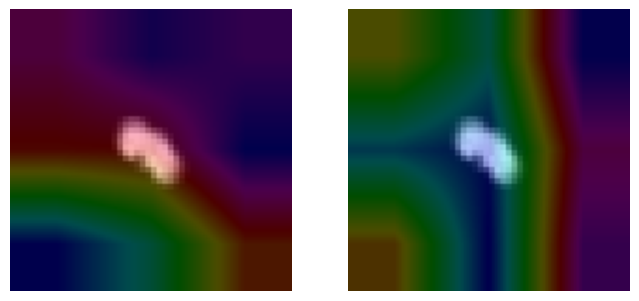

In [25]:
cam = CAM(model.calibrated_model)
grad_cam = GradCAM(model.calibrated_model)

pred_idx = np.argmax(pred)
heatmap = cam.compute_heatmap(test_img_tf, class_idx=pred_idx)
gradcam = grad_cam.compute_heatmap(test_img_tf, class_idx=pred_idx)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(overlay_heatmap(test_img, heatmap, alpha=.7, colormap=cv2.COLORMAP_HSV))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(overlay_heatmap(test_img, gradcam, alpha=.7, colormap=cv2.COLORMAP_HSV))
plt.axis('off')
plt.show()

In [31]:
model = CNN(
    base=tf.keras.applications.VGG16,
    input_shape=(100, 100, 3),
    n_classes=3
)
model.build_top(activation='softmax', b_type='CAM', pooling=ExtendedLSEPooling)
model.compile(
    lr=.001,
    loss=extended_w_cel_loss_multiclass(from_logits=True),
)

model_dir = '../models/cellular_division_models/vgg16_nuclei_under.h5'
model.load(model_dir, calibrated=False)